In [1]:
%cd /home/ubuntu/Qwen-Image-Edit-Angles

/home/ubuntu/Qwen-Image-Edit-Angles


In [8]:
import pandas as pd
from matplotlib import pyplot as plt

In [39]:
from qwenimage.experiment import ExperimentConfig
from qwenimage.experiments.experiments_qwen import ExperimentRegistry


experiment_names = ExperimentRegistry.keys()
report_dir = ExperimentConfig().report_dir

# Load all CSV results
all_results = []
for name in experiment_names:
    csv_path = report_dir / f"{name}.csv"
    
    df = pd.read_csv(csv_path, index_col=0)
    df['experiment'] = name
    all_results.append(df)
    print(f"Loaded results for {name}: {len(df)} rows")


Loaded results for qwen_base: 17 rows
Loaded results for qwen_fa3: 17 rows
Loaded results for qwen_aot: 18 rows
Loaded results for qwen_fa3_aot: 18 rows
Loaded results for qwen_fa3_aot_int8: 18 rows


In [ ]:
all_results[0]

,name,mean,std,len,experiment
0,QwenBaseExperiment.load,21.085774,0.000000,1,qwen_base
1,QwenBaseExperiment.optimize,0.000001,0.000000,1,qwen_base
2,Preprocessing,0.040042,0.002902,5,qwen_base
3,QwenImageEditPlusPipeline.encode_prompt,0.141252,0.082341,5,qwen_base
4,Encode Prompt,0.141295,0.082349,5,qwen_base
5,QwenImageEditPlusPipeline._encode_vae_image,0.102881,0.045868,5,qwen_base
6,Prep gen,0.105089,0.046743,5,qwen_base
7,loop 0,0.405985,0.037210,5,qwen_base
8,loop 1,0.435711,0.038597,5,qwen_base
9,loop 2,0.463708,0.011147,5,qwen_base


In [42]:
combined_df = pd.concat(all_results, ignore_index=True)
print(f"{combined_df.shape=}")
print(f"{combined_df.columns.tolist()=}")
combined_df.head(5)

combined_df.shape=(88, 5)
combined_df.columns.tolist()=['name', 'mean', 'std', 'len', 'experiment']


,name,mean,std,len,experiment
0,QwenBaseExperiment.load,21.085774,0.000000,1,qwen_base
1,QwenBaseExperiment.optimize,0.000001,0.000000,1,qwen_base
2,Preprocessing,0.040042,0.002902,5,qwen_base
3,QwenImageEditPlusPipeline.encode_prompt,0.141252,0.082341,5,qwen_base
4,Encode Prompt,0.141295,0.082349,5,qwen_base


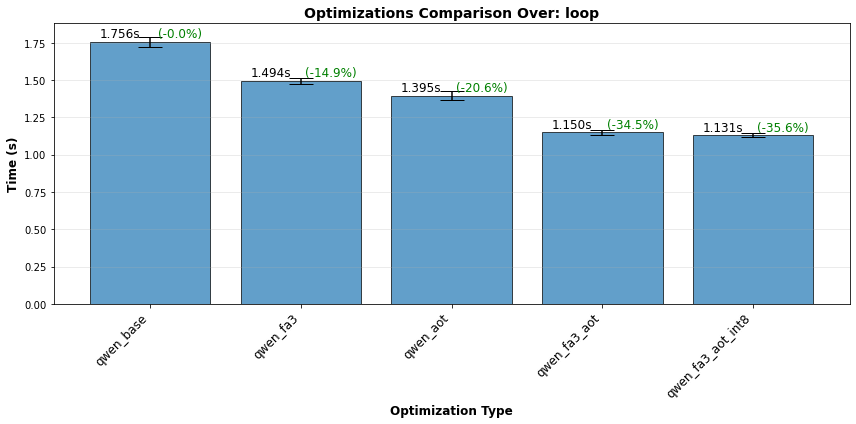

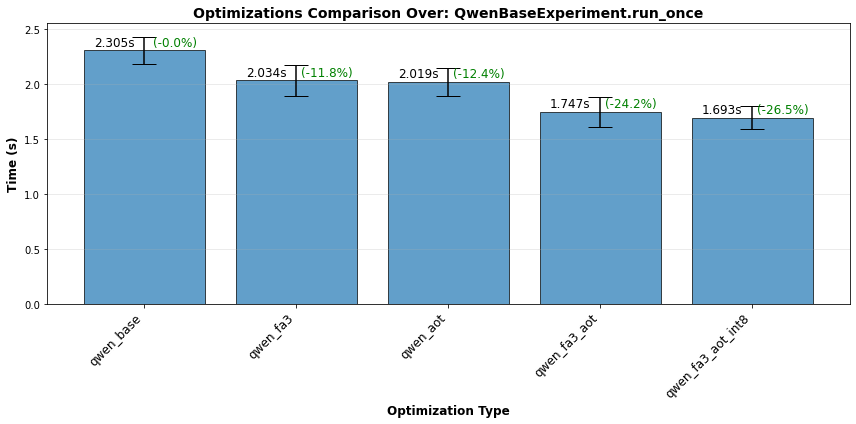

In [43]:
profile_targets = ["loop", "QwenBaseExperiment.run_once"]

for target in profile_targets:
    plot_data = combined_df[combined_df['name'] == target].copy()
    plot_data = plot_data.sort_values('mean', ascending=False)

    fig, ax = plt.subplots(figsize=(12, 6))

    x_pos = range(len(plot_data))
    
    # Get the maximum (slowest) time for percentage calculation
    max_time = plot_data['mean'].max()

    # Plot bars with error bars
    bars = ax.bar(x_pos, plot_data['mean'], yerr=plot_data['std'], 
                    capsize=12, alpha=0.7, edgecolor='black')

    # Customize plot
    ax.set_xlabel('Optimization Type', fontsize=12, fontweight='bold')
    ax.set_ylabel('Time (s)', fontsize=12, fontweight='bold')
    ax.set_title(f'Optimizations Comparison Over: {target}', 
                    fontsize=14, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels([row['experiment'] for _, row in plot_data.iterrows()], 
                        rotation=45, ha='right', fontsize=12)
    ax.grid(axis='y', alpha=0.3)

    # Add value labels on top of bars with percentage decrease
    for i, (idx, row) in enumerate(plot_data.iterrows()):        
        ax.text(i - 0.2, row['mean'] + 0.01, f"{row['mean']:.3f}s", 
                ha='center', va='bottom', fontsize=12)
        
        pct_decrease = ((max_time - row['mean']) / max_time) * 100
        ax.text(i + 0.2, row['mean'] + 0.01, f"(-{pct_decrease:.1f}%)", 
                ha='center', va='bottom', fontsize=12, color='green')
    
    

    plt.tight_layout()

    # Save plot
    plot_path = report_dir / f'{target}_performance_comparison.png'
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')

    plt.show()


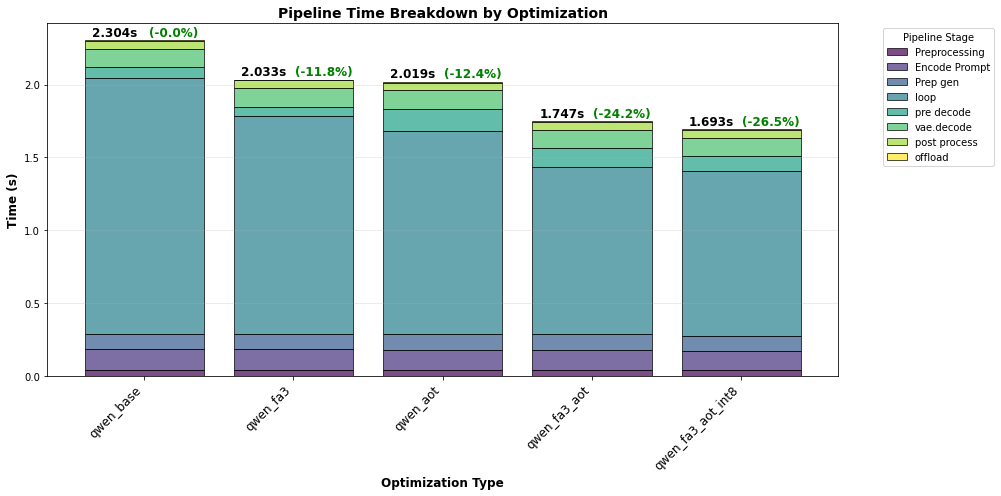


=== Time Breakdown Summary ===
name               Preprocessing  Encode Prompt  Prep gen   loop  pre decode  \
experiment                                                                     
qwen_base                   0.04          0.141     0.105  1.756       0.077   
qwen_fa3                    0.04          0.144     0.106  1.494       0.064   
qwen_aot                    0.04          0.139     0.107  1.395       0.153   
qwen_fa3_aot                0.04          0.140     0.107  1.150       0.125   
qwen_fa3_aot_int8           0.04          0.131     0.103  1.131       0.103   

name               vae.decode  post process  offload  
experiment                                            
qwen_base               0.127         0.052    0.005  
qwen_fa3                0.128         0.052    0.005  
qwen_aot                0.127         0.053    0.005  
qwen_fa3_aot            0.127         0.053    0.005  
qwen_fa3_aot_int8       0.128         0.052    0.005  

Total times:
experime

In [45]:
# Create stacked bar plot
stack_targets = ["Preprocessing", "Encode Prompt", "Prep gen", "loop", "pre decode", "vae.decode", "post process", "offload"]



# Filter data for the target stages
stack_data = combined_df[combined_df['name'].isin(stack_targets)].copy()

# Pivot the data so experiments are rows and stages are columns
pivot_data = stack_data.pivot(index='experiment', columns='name', values='mean')

# Reorder columns to match the desired order
pivot_data = pivot_data[stack_targets]

# Sort by total time (highest to lowest)
pivot_data['total'] = pivot_data.sum(axis=1)
pivot_data = pivot_data.sort_values('total', ascending=False)
pivot_data = pivot_data.drop('total', axis=1)

# Create the stacked bar plot
fig, ax = plt.subplots(figsize=(14, 7))

# Plot stacked bars
pivot_data.plot(kind='bar', stacked=True, ax=ax, 
                colormap='viridis', edgecolor='black', capsize=12, alpha=0.7, width=0.8)

# Customize plot
ax.set_xlabel('Optimization Type', fontsize=12, fontweight='bold')
ax.set_ylabel('Time (s)', fontsize=12, fontweight='bold')
ax.set_title('Pipeline Time Breakdown by Optimization', 
             fontsize=14, fontweight='bold')
ax.set_xticklabels(pivot_data.index, rotation=45, ha='right', fontsize=12)
ax.legend(title='Pipeline Stage', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax.grid(axis='y', alpha=0.3)

# Add total time labels on top of each bar with percentage improvement
max_time = pivot_data.sum(axis=1).max()
for i, (idx, row) in enumerate(pivot_data.iterrows()):
    total = row.sum()
    
    # Show time value
    ax.text(i - 0.2, total + 0.01, f'{total:.3f}s', 
            ha='center', va='bottom', fontsize=12, fontweight='bold')
    

    pct_decrease = ((max_time - total) / max_time) * 100
    ax.text(i + 0.2, total + 0.01, f'(-{pct_decrease:.1f}%)', 
            ha='center', va='bottom', fontsize=12, color='green', fontweight='bold')

plt.tight_layout()

# Save plot
plot_path = report_dir / 'stacked_time_breakdown.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight')

plt.show()

# Print summary table
print("\n=== Time Breakdown Summary ===")
print(pivot_data.round(3))
print(f"\nTotal times:")
print(pivot_data.sum(axis=1).round(3))
